# Machine Learning Project - Twitter Sentiment Analysis Using Spark

In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import col, udf
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

twitter_data = spark.read.json("twitter_data.json")

In [2]:
twitter_data.head()

Row(asin='B000F83SZQ', helpful=[0, 0], overall=5.0, reviewText="I enjoy vintage books and movies so I enjoyed reading this book.  The plot was unusual.  Don't think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.", reviewTime='05 5, 2014', reviewerID='A1F6404F1VG29J', reviewerName='Avidreader', summary='Nice vintage story', unixReviewTime=1399248000)

In [3]:
reviews = twitter_data[["reviewText","overall"]]

In [4]:
reviews.show(20)

+--------------------+-------+
|          reviewText|overall|
+--------------------+-------+
|I enjoy vintage b...|    5.0|
|This book is a re...|    4.0|
|This was a fairly...|    4.0|
|I'd never read an...|    5.0|
|If you like perio...|    4.0|
|A beautiful in-de...|    4.0|
|I enjoyed this on...|    4.0|
|Never heard of Am...|    4.0|
|Darth Maul workin...|    5.0|
|This is a short s...|    4.0|
|I think I have th...|    5.0|
|Title has nothing...|    4.0|
|Well written. Int...|    3.0|
|Troy Denning's no...|    3.0|
|I am not for sure...|    5.0|
|I really enjoyed ...|    5.0|
|Great read enjoye...|    5.0|
|Another well writ...|    3.0|
|This one promises...|    5.0|
|I have a version ...|    4.0|
+--------------------+-------+
only showing top 20 rows



In [5]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [6]:
sqlContext.registerDataFrameAsTable(reviews, "table2")
reviews1 = sqlContext.sql("SELECT reviewText, overall from table2 LIMIT 50000")

In [7]:
reviews1.show(20)


+--------------------+-------+
|          reviewText|overall|
+--------------------+-------+
|I enjoy vintage b...|    5.0|
|This book is a re...|    4.0|
|This was a fairly...|    4.0|
|I'd never read an...|    5.0|
|If you like perio...|    4.0|
|A beautiful in-de...|    4.0|
|I enjoyed this on...|    4.0|
|Never heard of Am...|    4.0|
|Darth Maul workin...|    5.0|
|This is a short s...|    4.0|
|I think I have th...|    5.0|
|Title has nothing...|    4.0|
|Well written. Int...|    3.0|
|Troy Denning's no...|    3.0|
|I am not for sure...|    5.0|
|I really enjoyed ...|    5.0|
|Great read enjoye...|    5.0|
|Another well writ...|    3.0|
|This one promises...|    5.0|
|I have a version ...|    4.0|
+--------------------+-------+
only showing top 20 rows



In [8]:
#positive->1
#negative->0
def transform(star):
    if star >=3:
        return 1
    else:
        return 0
transformer = udf(transform)

In [9]:
df = reviews1.withColumn("label", transformer(reviews['overall']))

In [10]:
sqlContext.registerDataFrameAsTable(df, "table1")
df2 = sqlContext.sql("SELECT reviewText, label from table1 WHERE reviewText != ''")

In [11]:
(training, test) = df2.randomSplit([0.9, 0.1])

In [12]:
training.show(12)

+--------------------+-----+
|          reviewText|label|
+--------------------+-----+
|"'Looking Through...|    1|
|"'Reflections at ...|    1|
|"*69" starts with...|    1|
|"... Couldn't you...|    1|
|"...This is the s...|    1|
|"...the world is ...|    1|
|"A Dundee Christm...|    1|
|"A Hero for Jessi...|    1|
|"A Secret in the ...|    1|
|"A Work in Progre...|    1|
|"A professional i...|    1|
|"Abused" is a sho...|    1|
+--------------------+-----+
only showing top 12 rows



In [13]:
training

DataFrame[reviewText: string, label: string]

In [14]:
regexTokenizer = RegexTokenizer(inputCol="reviewText", outputCol="words", pattern="\\W")
# alternatively, pattern="\\w+", gaps(False)
countTokens = udf(lambda words: len(words), IntegerType())

In [15]:
regexTokenized = regexTokenizer.transform(training)
regexTokenized.select("reviewText", "words") \
    .withColumn("tokens", countTokens(col("words"))).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
regexTokenized.head()

Row(reviewText='"\'Looking Through Lace" \'is the story of Toni, a xenolinguist who is assigned to work with a first contact team. She\'s been relegated to doing grunt work until now, and is really excited for the opportunity to prove herself.The alien world in \'"Looking Through Lace" \'is fascinating - although the inhabitants are descended from humans, they have a unique history and culture. The women speak an entirely different language among themselves that the men are not allowed to learn, and Toni is determined to figure out how and why that happened. However, she has a jealous senior colleague and the affections of an attractive native (who just happens to be in a group marriage) to contend with.I enjoyed reading a science-fiction story by Nestvold; all the other work I\'ve read by her has been fantasy. She keeps up the excellent worldbuilding and characters. I found the revelations concerning the history of the world very interesting. The antagonist xenolinguist seemed like a 

In [17]:
htf = HashingTF(inputCol="words", outputCol="features")
tf = htf.transform(regexTokenized)
train = tf[["label","features"]]

In [18]:
types = [f.dataType for f in train.schema.fields]
types

[StringType, VectorUDT]

In [19]:
train2 = train.withColumn("label",train["label"].cast(DoubleType()))
types = [f.dataType for f in train2.schema.fields]
types

[DoubleType, VectorUDT]

In [20]:
train2

DataFrame[label: double, features: vector]

In [21]:
train2.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(262144,[14,4081,...|
|  1.0|(262144,[14,2366,...|
|  1.0|(262144,[14,619,1...|
|  1.0|(262144,[325,378,...|
|  1.0|(262144,[9639,158...|
|  1.0|(262144,[1879,963...|
|  1.0|(262144,[1998,420...|
|  1.0|(262144,[6061,644...|
|  1.0|(262144,[2710,392...|
|  1.0|(262144,[14,4282,...|
|  1.0|(262144,[5419,963...|
|  1.0|(262144,[14,8976,...|
|  1.0|(262144,[3561,420...|
|  1.0|(262144,[5813,695...|
|  1.0|(262144,[6051,880...|
|  1.0|(262144,[9559,963...|
|  1.0|(262144,[4200,508...|
|  1.0|(262144,[2710,306...|
|  1.0|(262144,[1889,863...|
|  1.0|(262144,[14,2437,...|
+-----+--------------------+
only showing top 20 rows



In [22]:
test.show()

+--------------------+-----+
|          reviewText|label|
+--------------------+-----+
|!!!!??? (sorry co...|    1|
|"A Hard Man is Go...|    1|
|"Angel Be Good" i...|    1|
|"Ashes" is an ant...|    1|
|"Bound by Decepti...|    1|
|"Have You Seen He...|    1|
|"Have you ever wo...|    1|
|"How would you fe...|    1|
|"LASTING LOVE" BY...|    1|
|"Minnie, from Got...|    1|
|"Reluctant" fits ...|    1|
|"Sex is only dirt...|    1|
|"The Black God's ...|    1|
|"The Elegant Corp...|    1|
|"The Right Path" ...|    1|
|"The Salisury Key...|    1|
|"The Secret Apoca...|    1|
|"We both know thi...|    1|
|"Where was the su...|    1|
|"Zellwood:  A Dog...|    1|
+--------------------+-----+
only showing top 20 rows



In [23]:
regexTokenized_test = regexTokenizer.transform(test)
regexTokenized.select("reviewText", "words") \
    .withColumn("tokens", countTokens(col("words"))).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [24]:
tf_test = htf.transform(regexTokenized_test)
testSet = tf_test[["label","features"]]
testSet = testSet.withColumn("label",testSet["label"].cast(DoubleType()))
arr=[]

# SUPPORT VECTOR MACHINE

In [25]:
lsvc = LinearSVC(maxIter=10, regParam=0.1)
model = lsvc.fit(train2)

In [26]:
prediction = model.transform(testSet)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction)
print("Test Error = %g " % (1.0 - accuracy))
accuracy=accuracy*100
print("Accuracy = %g " % accuracy)
arr.append(accuracy)

Test Error = 0.0834835 
Accuracy = 91.6517 


# LOGISTIC REGRESSION 

In [27]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
pipeline = Pipeline(stages=[lr])
model = pipeline.fit(train2)

In [28]:
prediction = model.transform(testSet)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction)
print("Test Error = %g " % (1.0 - accuracy))
accuracy=accuracy*100
print("Accuracy = %g " % accuracy)
arr.append(accuracy)

Test Error = 0.0982983 
Accuracy = 90.1702 


# ONE VS REST CLASSIFIER

In [29]:
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
ovr = OneVsRest(classifier=lr)
model = ovr.fit(train2)

In [30]:
prediction = model.transform(testSet)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction)
print("Test Error = %g " % (1.0 - accuracy))
accuracy=accuracy*100
print("Accuracy = %g " % accuracy)
arr.append(accuracy)

Test Error = 0.0862863 
Accuracy = 91.3714 


# NAIVEBAYES

In [31]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
model = nb.fit(train2)

In [32]:
prediction = model.transform(testSet)

In [33]:
prediction = model.transform(testSet)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction)
print("Test Error = %g " % (1.0 - accuracy))
accuracy=accuracy*100
print("Accuracy = %g " % accuracy)

Test Error = 0.0984985 
Accuracy = 90.1502 


In [34]:
arr.append(accuracy)

In [35]:
arr2=[]
arr2=['SVM','Logistic Regression','OneVSRest Classifier','NaiveBayes','TextBlob']
arr.append(90.93453368980366)

# RESULT ANALYSIS

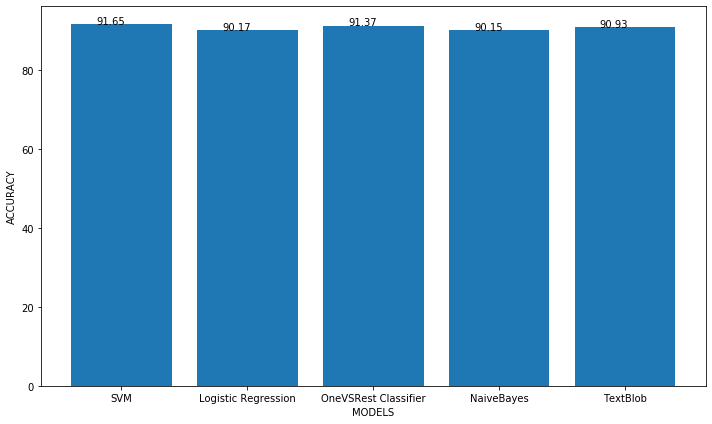

In [38]:
import matplotlib.pyplot as plt
plt.xlabel('MODELS')
plt.ylabel('ACCURACY')
bars = plt.bar(arr2,arr)
for bar in bars:
    yval = round(bar.get_height(),2)
    plt.text(bar.get_x()+0.2, round((yval + .005),2), yval)
plt.rcParams['figure.figsize'] = [10, 6]
plt.tight_layout()

In [37]:
sc.stop()